# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%matplotlib inline
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from PIL import Image
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [2]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    dataset_dicts = []
    img_idx = -1
    for img_file in os.listdir(img_dir):
        if '.bmp' not in img_file and '.png' not in img_file:
            continue
        img_idx += 1
        img_file = os.path.join(img_dir, img_file)
        height, width = cv2.imread(img_file).shape[:2]
        record = {}

        record["file_name"] = img_file
        record["image_id"] = img_idx
        record["height"] = height
        record["width"] = width

        objs = []
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("BoxData_" + d, lambda d=d: get_balloon_dicts("BoxData/" + d))
    MetadataCatalog.get("BoxData_" + d).set(thing_classes=["Box"])
balloon_metadata = MetadataCatalog.get("BoxData_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



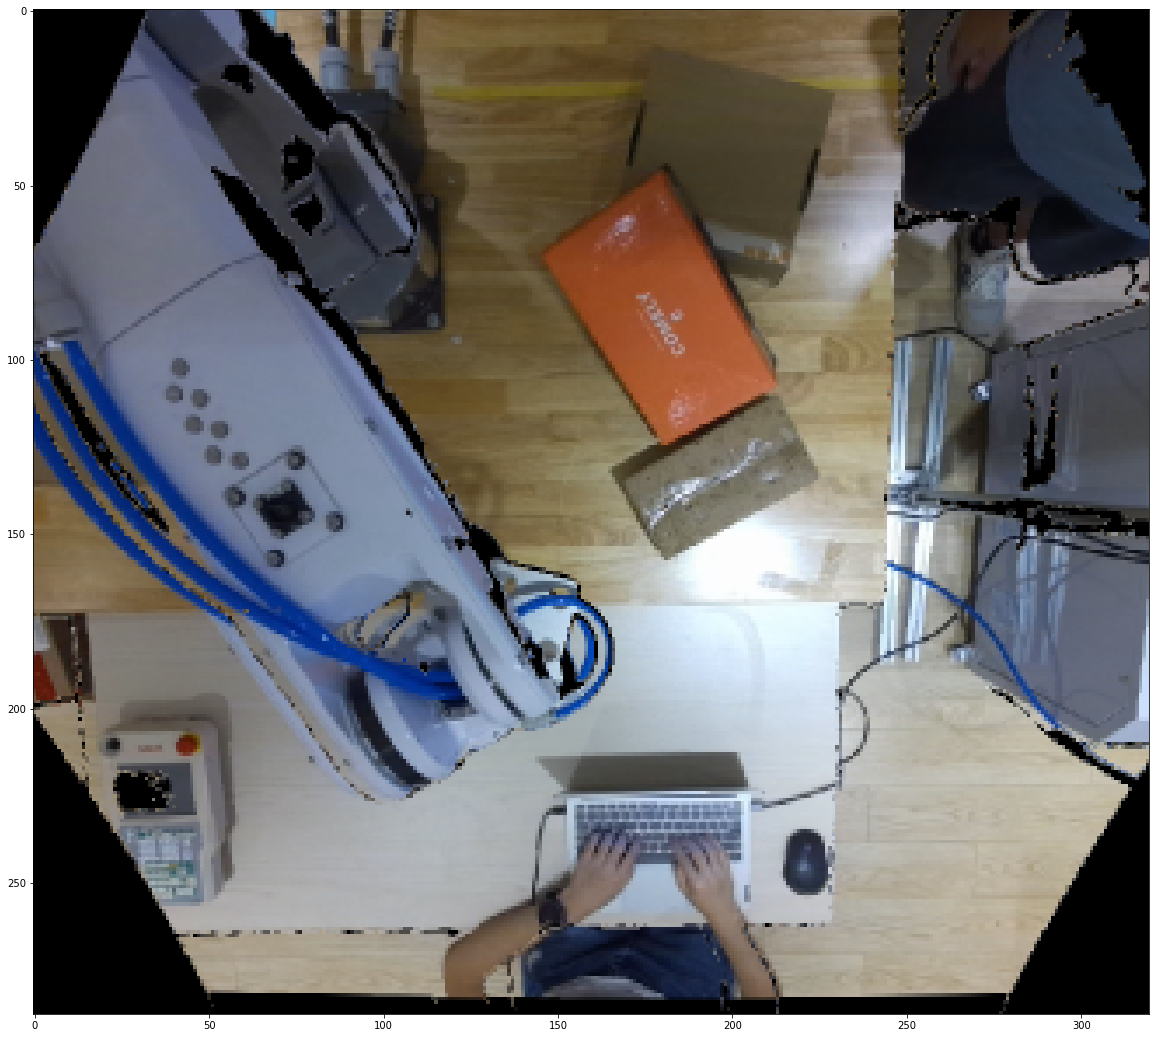

In [3]:
dataset_dicts = get_balloon_dicts("BoxData/val")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(out.get_image())
    plt.show()

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [5]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("BoxData_train",)
cfg.DATASETS.TEST = ("BoxData_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
# cfg.MODEL.DEVICE = "cpu"


In [8]:
cfg.

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': './output/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEI

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("BoxData_val", )
predictor = DefaultPredictor(cfg)

In [16]:
im = cv2.imread(r'./BoxData/val/img86_colorRevise.png')
outputs = predictor(im)

In [19]:
inst = outputs['instances']

In [54]:
box = inst.get_fields()['pred_boxes']

In [59]:
box.tensor

tensor([[284.9461, 118.4498, 387.9980, 277.2227],
        [368.3648, 116.1976, 458.9856, 266.9618],
        [ 53.3735, 376.5631, 193.1819, 505.8222],
        [262.3996,  56.9351, 394.9645, 140.6036]], device='cuda:0')

In [22]:
inst.get_fields()zz

Instances(num_instances=4, image_height=576, image_width=640, fields=[pred_boxes: Boxes(tensor([[284.9461, 118.4498, 387.9980, 277.2227],
        [368.3648, 116.1976, 458.9856, 266.9618],
        [ 53.3735, 376.5631, 193.1819, 505.8222],
        [262.3996,  56.9351, 394.9645, 140.6036]], device='cuda:0')), scores: tensor([0.9984, 0.9980, 0.9966, 0.9925], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,

In [60]:
inst.pred_masks.shape

torch.Size([4, 576, 640])

In [64]:
arr = inst.pred_masks.cpu().numpy()

In [72]:
arr.shape

(4, 576, 640)

In [82]:
a = np.argmax(arr , axis=2)
b = arr.shape[2] - np.argmax(arr[:,:,::-1] , axis=2) -1
b[b==arr.shape[2] - 1]  =0

In [ ]:
np.where( arr - arr[]> 0)

In [65]:
cor = np.where( arr> 0)

In [66]:
cor

(array([0, 0, 0, ..., 3, 3, 3]),
 array([124, 124, 124, ..., 139, 139, 139]),
 array([352, 353, 354, ..., 280, 281, 282]))

In [41]:
import torch
import json

In [45]:
json.dumps([[[1,2]]])

'[[[1, 2]]]'

In [43]:
json.dumps(np.where(inst.pred_masks.cpu().numpy() > 0))

TypeError: Object of type 'ndarray' is not JSON serializable

In [11]:
outputs["pred_masks"]

KeyError: 'pred_masks'

In [ ]:
[x.tolist() for x in np.where(inst.pred_masks.cpu().numpy() > 0)]

Then, we randomly select several samples to visualize the prediction results.

In [18]:
from detectron2.utils.visualizer import ColorMode
import time
time_cnt = 0
dataset_dicts = get_balloon_dicts("BoxData/train")
cnt = 0
for d in random.sample(dataset_dicts, len(dataset_dicts)):   
    print(d["file_name"]) 
    im = cv2.imread(d["file_name"])
    print(im.shape)
    time_start = time.time()
    outputs = predictor(im)
    time_cnt += time.time() - time_start; 
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=1, 
                #    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(r"imgs/"+d["file_name"][14:]+".png", out.get_image()[:, :, ::-1])
    
    # plt.figure(figsize=(20, 20))
    # plt.imshow(out.get_image()[:, :])
    # plt.show()
time_cnt / 10

BoxData/train/img72_colorRevise.png
(576, 640, 3)
BoxData/train/img64_colorRevise.png
(576, 640, 3)
BoxData/train/img77_colorRevise.png
(576, 640, 3)
BoxData/train/img38_colorRevise.png
(576, 640, 3)
BoxData/train/img21_colorRevise.png
(576, 640, 3)
BoxData/train/img03_colorRevise.png
(576, 640, 3)
BoxData/train/img10_colorRevise.png
(576, 640, 3)
BoxData/train/img17_colorRevise.png
(576, 640, 3)
BoxData/train/img29_colorRevise.png
(576, 640, 3)
BoxData/train/img44_colorRevise.png
(576, 640, 3)
BoxData/train/img70_colorRevise.png
(576, 640, 3)
BoxData/train/img35_colorRevise.png
(576, 640, 3)
BoxData/train/img83_colorRevise.png
(576, 640, 3)
BoxData/train/img53_colorRevise.png
(576, 640, 3)
BoxData/train/img33_colorRevise.png
(576, 640, 3)
BoxData/train/img08_colorRevise.png
(576, 640, 3)
BoxData/train/img58_colorRevise.png
(576, 640, 3)
BoxData/train/img62_colorRevise.png
(576, 640, 3)
BoxData/train/img78_colorRevise.png
(576, 640, 3)
BoxData/train/img66_colorRevise.png
(576, 640, 3)


0.5371663808822632

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("BoxData_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "BoxData_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[08/10 11:19:17 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[08/10 11:19:17 d2.data.common]: Serialized dataset takes 0.00 MiB
[08/10 11:19:17 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/10 11:19:17 d2.evaluation.evaluator]: Start inference on 11 images
[08/10 11:19:18 d2.evaluation.evaluator]: Inference done 11/11. 0.0562 s / img. ETA=0:00:00
[08/10 11:19:18 d2.evaluation.evaluator]: Total inference time: 0:00:00.390011 (0.065002 s / img per device, on 1 devices)
[08/10 11:19:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.056207 s / img per device, on 1 devices)
[08/10 11:19:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/10 11:19:18 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[08/10 11:19:18 d2.evaluation.coco_evaluation]: Evaluating pred

AssertionError: Results do not correspond to current coco set